# PoC of Recommender System for safe and efficient Food Deliveries during Infectious Disease induced Lockdowns

Course "IBM Data Science", Capstone Project, April 2020 by [Markus Mächler](https://www.linkedin.com/in/markus-maechler/)

_written and tested with Jupyter Notebook 6.0.3 (with Python 3.7.6 on Win10x64 and MacOS 10.15.4)_

**Folium maps are not rendered on github. For the best experience, [please view this notebook with this link](https://nbviewer.jupyter.org/github/Funisher-code/Coursera_Capstone/blob/master/notebook/POC_food_delivery_recommender_system.ipynb).**

----

## Introduction

### Major problems during a lockdown concerning shopping / food deliveries
1. keep people at risk **safe but not hungry**
2. keep shops and restaurants **up and running**
3. use helpers as **efficiently and safely** as possible

The purpose of this project is creating a small POC (proof of concept) to help tackling our three problems by creating a simple but efficient recommender system that could be used to place actual orders.

**For more background information, [read the full report here](https://github.com/Funisher-code/Coursera_Capstone/blob/master/report/COVID-19_Safe_And_Efficient_Food_Deliveries.md).**

## Data + Methodology

### Location Data

For every order, **location data of all the three parties** is absolutely necessary. For this POC I'm using the following data sources.

- customers: **hypothetical address of a customer in Zurich**
- helpers: **hypothetical addresses in Zurich**
- shops: **Foursquare location data** acquired via API in the vicinity of people at risk


### install dependencies if not already installed

In [1]:
# map rendering library

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment if not installed already

In [2]:
# used to locate the coordinates of addresses, cities, countries, and landmarks across the globe
# using third-party geocoders and other data sources

#!conda install -c conda-forge geopy --yes # uncomment if not installed already

In [3]:
# install python library to generate fake data

#!conda install -c conda-forge faker --yes # uncomment if not installed already

### import necessary libraries

In [4]:
from geopy.geocoders import Nominatim
import geopy.distance
import folium 
from collections import namedtuple
import pandas as pd                                    # for working with dataframes
import numpy as np                                     # for workig with matrizes
from scipy import stats                                # for getting quick descriptive statistics
import matplotlib.pyplot as plt                        # for plotting
from  matplotlib.colors import LinearSegmentedColormap # to define custom colored maps in our plots
import requests                                        # to handle requests
import time                                            # used to sleep for a defined amount of time
from faker import Faker                                # to generate fake person data

print('Libraries imported.')

Libraries imported.


### customer location data

Let's define an address of a customer to work with. This would simply be something a customer would have to specify upon signing up. I just picked one at random.

In [5]:
custAddr = 'Gsteigstrasse 9, 8049 Zurich'

Now we define an instance of geocoder with user agent _food_explorer_.

And we use it to convert our customer address to a location in terms of latitude and longitude.

In [6]:
geolocator = Nominatim(user_agent="food_explorer")
location = geolocator.geocode(custAddr)
custLatitude = location.latitude
custLongitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(custAddr, custLatitude, custLongitude))

The geograpical coordinate of Gsteigstrasse 9, 8049 Zurich are 47.4028839, 8.499580847726023.


Let's quickly check if the coordinates reflect the addess of the customer.

In [7]:
# create map of Zurich using the latitude and longitude value generated by geocoder
map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=15)

# add marker of our address to the map
label = custAddr
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [custLatitude, custLongitude],
    radius=5,
    popup=label,
    color='red',
    parse_html=False).add_to(map_folium)  
    
map_folium

Again, if you can't see the map above, that's totally normal github behaviour. [Please view this notebook with this link](https://nbviewer.jupyter.org/github/Funisher-code/Coursera_Capstone/blob/master/notebook/POC_food_delivery_recommender_system.ipynb).

Back to Geolocator. That certainly looks like Zurich but let's zoom all in to make sure it's accurate.

In [8]:
# create map of Zurich using the latitude and longitude value generated by geocoder
map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=18)

# add marker of our address to the map
label = custAddr
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [custLatitude, custLongitude],
    radius=10,
    popup=label,
    color='red',
    parse_html=False).add_to(map_folium)  
    
map_folium

Nice, that's something we can work with.

So customers signing up for the delivery service can simply specify their address as location data.

<a id = "tldr1back"></a>
### helper location data 

Just like with our customer we will use a Nominatom geolocator to convert our helper addresses to geolocations.

Unlike with the freshly signed up customer, we will import a list I created with __fictional helper data__ in the vicinity of our customer.

_TLDR alert, if you don't care how I got this data, leave the next session out [by clicking here to import the resulting csv](#tldr1)._
.

.

.

.

.

.

.

.

.

.

.

Or you can take the long way

.

.

.

.

.

.

**Thanks for staying with me. Here's what I did:**

1. query https://tel.search.ch/ for the postal code 8049, since that's where our customer lives.
2. copy all search results from the website. that looks something like this:
```
name01, surname01	
name01, surname01
street01 number01, 8049 Zürich
044 123 45 67
Details
name02, surname02	
name02, surname02
street02 number02, 8049 Zürich
044 765 43 21 *
Details
```
3. use some powerful editor: get rid of leading and trailing garbage, then convert to a usable csv format. I was on Win10 then and used notepad++ for the following:
 - search for "\n" and replace with ";" since "," is already widely used in the addresses
 - search for "\r" and "\t" and replace with nothing
 - search for ";Details;" and replace with "\n"


4. what we now have resembles something like this:
```
name01, surname01;name01, surname01;street01 number01, 8049 Zürich;044 123 45 67
name02, surname02;name02, surname02;street02 number02, 8049 Zürich;044 765 43 21 *
...
```

First we import the resulting file to a pandas dataframe. **I tried the following code:**

```python
helperData=pd.read_csv('helperAddr_raw.csv', sep=';', header=None)
```

This leads to the following error:

```python
ParserError: Error tokenizing data. C error: Expected 4 fields in line 51, saw 5
```

That didn't work. What happened? After inspection of line 51 I realized that there are cases, where people also specify professions. This results in an additional column.

**This is just another example why carefully curing your raw data is both important and time consuming.**

For our purpose I'll just skip rows that don't match the number of columns.

In [9]:
helperData=pd.read_csv('helperAddr_raw.csv', sep=';', header=None, error_bad_lines=False)

b'Skipping line 4: expected 4 fields, saw 5\nSkipping line 5: expected 4 fields, saw 5\nSkipping line 8: expected 4 fields, saw 5\nSkipping line 10: expected 4 fields, saw 5\nSkipping line 11: expected 4 fields, saw 5\nSkipping line 12: expected 4 fields, saw 5\nSkipping line 14: expected 4 fields, saw 5\nSkipping line 16: expected 4 fields, saw 5\nSkipping line 17: expected 4 fields, saw 5\nSkipping line 21: expected 4 fields, saw 5\nSkipping line 23: expected 4 fields, saw 5\nSkipping line 27: expected 4 fields, saw 5\nSkipping line 28: expected 4 fields, saw 5\nSkipping line 33: expected 4 fields, saw 5\nSkipping line 39: expected 4 fields, saw 5\nSkipping line 41: expected 4 fields, saw 5\nSkipping line 42: expected 4 fields, saw 5\nSkipping line 43: expected 4 fields, saw 5\nSkipping line 44: expected 4 fields, saw 5\nSkipping line 46: expected 4 fields, saw 5\nSkipping line 48: expected 4 fields, saw 5\nSkipping line 50: expected 4 fields, saw 5\nSkipping line 53: expected 4 fiel

That's quite some skipped lines. Let's see how many addresses we got:

In [10]:
helperData.shape

(130, 4)

So after skipping quite some rows this resulted in 130 unique "fictional helpers".

By the way, the **asterik after the phone number** signifies, that the holder of the number doesn't want to get bothered by ad calls.

**Allthough this is all puplicly available information, let's get rid of all names and phone numbers.**

Then we name the remaining column address and have a look at the first 5 rows.

In [11]:
helperData.drop(columns=[0,1,3], inplace=True)
helperData.rename(columns={2:'address'}, inplace=True)
helperData.head()

,address
0,"Michelstrasse 6, 8049 Zürich"
1,"Riedhofstrasse 277, 8049 Zürich"
2,"Brunnwiesenstrasse. 78, 8049 Zürich"
3,"Rütihofstrasse 32, 8049 Zürich"
4,"Segantinistrasse 38, 8049 Zürich"


In [12]:
helperData.to_csv('helperData_addresses.csv',sep=';') # save dataframe to a csv

<a id = "tldr1"></a>
#### TLDR off

If you don't want to perform the manual steps up above you may join again from here.

Or if you accidentally missed the fun part or just made up your mind, you can [click here to go back](#tldr1back).

If you're not interested in enriching the helper dataframe with geolocation and fake email data, [you can skip that and jump to the next part, where we're visualizing the helper and customer locations on a map.](#tldr1evenfurther).



**Again, thanks for your interest and sticking with me.**

Let's import the csv containing our addresses.

In [13]:
helperData=pd.read_csv('helperData_addresses.csv',sep=';') # import csv that resulted from manual data gathering
helperData.drop(columns=['Unnamed: 0'], inplace=True) # drop the unnamed column with the row numbers
helperData.head()

,address
0,"Michelstrasse 6, 8049 Zürich"
1,"Riedhofstrasse 277, 8049 Zürich"
2,"Brunnwiesenstrasse. 78, 8049 Zürich"
3,"Rütihofstrasse 32, 8049 Zürich"
4,"Segantinistrasse 38, 8049 Zürich"


In the next step, we us geolocator again to convert our helper addresses to locations.

I had to find out that too many requests in a short time leads to timeouts and the for loop to crash all the time.
But the **following combination of a try block and sleep function workes just fine**: 

In [14]:
helpLat=[] # list to store latitutes
helpLong= [] # list to store longitudes
location=None # variable to check if geolocator returned a results
count=0 # counter for converted addresses 

print('starting geolocator conversion:')
for tmpAddr in helperData['address']:
    while(location is None): # try to use geolocator until a result is returned
        try: 
            location = geolocator.geocode(tmpAddr) # try converting address to gps position
            count+=1
            helpLat.append(location.latitude) # append latitude to list
            helpLong.append(location.longitude) # append longitude to list
            print('row',count,'converted:',tmpAddr,'to',location.latitude,',',location.longitude)
        except: # in case geocoder times out, wait half a second 
            #print('.',end='') # uncomment to see how many attempts failed
            time.sleep(0.5) #wait half a second
    location=None

starting geolocator conversion:
row 1 converted: Michelstrasse 6, 8049 Zürich to 47.4045882 , 8.4956993
row 2 converted: Riedhofstrasse 277, 8049 Zürich to 47.4068335 , 8.486364788336479
row 3 converted: Brunnwiesenstrasse. 78, 8049 Zürich to 47.401818899999995 , 8.502904109747357
row 4 converted: Rütihofstrasse 32, 8049 Zürich to 47.4139362 , 8.477824429475469
row 5 converted: Segantinistrasse 38, 8049 Zürich to 47.405278499999994 , 8.500653449999996
row 6 converted: Riedhofstrasse 63, 8049 Zürich to 47.4047016 , 8.492083950865386
row 7 converted: Riedhofstrasse 299, 8049 Zürich to 47.4077043 , 8.4850702
row 8 converted: Imbisbühlstrasse 17, 8049 Zürich to 47.403117 , 8.4936818
row 9 converted: Limmattalstrasse 266, 8049 Zürich to 47.4023642 , 8.4938806
row 10 converted: Im Wingert 12, 8049 Zürich to 47.4003858 , 8.509406051787845
row 11 converted: Kettberg 5, 8049 Zürich to 47.398512049999994 , 8.511144443967313
row 12 converted: Riedhofstrasse 29, 8049 Zürich to 47.40424195 , 8.4934

row 99 converted: Reinhold-Frei-Strasse 67, 8049 Zürich to 47.4105669 , 8.483620068895908
row 100 converted: Riedhofstrasse 41, 8049 Zürich to 47.4039369 , 8.4929601
row 101 converted: Rütihofstrasse 31, 8049 Zürich to 47.4135121 , 8.478689754897568
row 102 converted: Regensdorferstrasse 157, 8049 Zürich to 47.4034924 , 8.4973495
row 103 converted: Im oberen Boden 72, 8049 Zürich to 47.416623 , 8.481363723023257
row 104 converted: Segantinistrasse 63, 8049 Zürich to 47.4054201 , 8.498685540823669
row 105 converted: Rebbergstrasse 65, 8049 Zürich to 47.3977891 , 8.5115899
row 106 converted: Appenzellerstrasse 55, 8049 Zürich to 47.4006704 , 8.507789952394452
row 107 converted: Kappenbühlweg 11, 8049 Zürich to 47.40397745 , 8.498320080768725
row 108 converted: Heizenholz 45, 8049 Zürich to 47.411592299999995 , 8.485578726437662
row 109 converted: Frankentalerstrasse 35, 8049 Zürich to 47.40705455 , 8.479552765429101
row 110 converted: Bauherrenstrasse 48, 8049 Zürich to 47.40106799999999

In [15]:
print('Number of elements in the list helpLat: ',len(helpLat))
print('Number of elements in the list helpLong:',len(helpLong))

Number of elements in the list helpLat:  130
Number of elements in the list helpLong: 130


Seems to have worked.

Now let's **add the resulting geoposition rows to our helper dataframe**, name the columns and have a look at the resulting dataframe.

In [16]:
helperData['latitude']=helpLat
helperData['longitude']=helpLong
helperData.index.name='helperId'
helperData.head()

,address,latitude,longitude
helperId,,,
0,"Michelstrasse 6, 8049 Zürich",47.404588,8.495699
1,"Riedhofstrasse 277, 8049 Zürich",47.406833,8.486365
2,"Brunnwiesenstrasse. 78, 8049 Zürich",47.401819,8.502904
3,"Rütihofstrasse 32, 8049 Zürich",47.413936,8.477824
4,"Segantinistrasse 38, 8049 Zürich",47.405278,8.500653


In [17]:
helperData.tail()

,address,latitude,longitude
helperId,,,
125,"Riedhofweg 4, 8049 Zürich",47.408466,8.484372
126,"Kürbergstrasse 50, 8049 Zürich",47.398748,8.510023
127,"Riedhofstrasse 70, 8049 Zürich",47.405314,8.492104
128,"Winzerhalde 85, 8049 Zürich",47.402491,8.485379
129,"Gsteigstrasse 31, 8049 Zürich",47.403059,8.501921


Now we **create and add some fake email addresses** for our helpers:

In [18]:
# create a list of fake names and email addresses
fake = Faker(['de_DE']) 
helperEmail=[]
for i in range(len(helperData)):
    helperEmail.append(fake.email())

In [19]:
# check result
helperEmail[:5]

['olena23@web.de',
 'abdul37@lorch.de',
 'ron06@etzler.org',
 'stanislaw11@gorlitz.com',
 'dorleboerner@aol.de']

In [20]:
# add fake email addresses to our dataframe
helperData['email']=helperEmail

Have a final look at our dataframe:

In [21]:
helperData.head()

,address,latitude,longitude,email
helperId,,,,
0,"Michelstrasse 6, 8049 Zürich",47.404588,8.495699,olena23@web.de
1,"Riedhofstrasse 277, 8049 Zürich",47.406833,8.486365,abdul37@lorch.de
2,"Brunnwiesenstrasse. 78, 8049 Zürich",47.401819,8.502904,ron06@etzler.org
3,"Rütihofstrasse 32, 8049 Zürich",47.413936,8.477824,stanislaw11@gorlitz.com
4,"Segantinistrasse 38, 8049 Zürich",47.405278,8.500653,dorleboerner@aol.de


Looks good to me.

How about saving our work to a csv in case anything goes wrong:

In [22]:
helperData.to_csv('helperData.csv')

**With that, our manual data gathering part for our ficticious helpers and customer is done.**

----

<a id = "tldr1evenfurther"></a>
### customers and helper geolocations visualized on a map
Now let's visualize the helpers and our customer on the map.

The customer is represented with a red circle and the possible helpers with blue circles.

In [23]:
# helperData = pd.read_csv('helperData.csv') # uncomment in case you want to proceed from here

In [24]:
# create map of Zurich using the latitude and longitude values generated by geocoder
map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=15)

# add a red cirle for the position of our customer to the map
label = custAddr
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [custLatitude, custLongitude],
    radius=10,
    popup=label,
    color='red',
    parse_html=False).add_to(map_folium)  

# add smaller blue circles for helpers
for email, lat, lng in zip(helperData['email'], helperData['latitude'], helperData['longitude']):    
    label = email
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#1234cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_folium)  

map_folium

Very nice. Let's hope that we have that many helpers in the real world.

### shops - get Foursquare location data

Right now we have a customer and possible helpers. But we still need positions of shops or restaurants where the helpers can fetch the goods and bring them to the customer. 

For that will use realtime data we get by querying the Foursquare API. So we're finally done with fake data.

First of all, we're gonna read the necessary Foursquare credentials and version **from the local File "cred_foursquare.json"**

this json could resemble the following structure:
```json
{
      "name": "Password JSON",
      "version": "1.0.0",
      "description": "",
      "command": "",
      "log": "",
      "location": "",
      "timeout": "0",
      "commandargs": "",
      "keys":
      [
         {
          "scriptkey": "VERSION",
          "scriptvalue": "20180605",
          "scriptdefaultvalue": ""
         },
   {
          "scriptkey": "ID",
          "scriptvalue": "***************************"
          "scriptdefaultvalue": ""
         },
   {
          "scriptkey": "SECRET",
          "scriptvalue": "***************************",
          "scriptdefaultvalue": "",
          "type": "password"
         }
      ]
}
```

The ID and SECRET can be obtained for free on https://developer.foursquare.com/ by registering for a free developer account.

After saving the credentials in the file "cred_foursquare.json" we can load the values into variables.

In [25]:
cred=pd.read_json(r'cred_foursquare.json') # read the json file

In [26]:
VERSION=cred['keys'][0]['scriptvalue'] # Foursquare API version
CLIENT_ID=cred['keys'][1]['scriptvalue'] # Foursquare ID
CLIENT_SECRET=cred['keys'][2]['scriptvalue'] # Foursquare Secret
LIMIT=100 # max number of answers because number of queries on the free account are limited

Now let's think about __what type of venues__ we want to include as possible shops / restaurants 

Everybody can have a look at all of Foursquare's venue categories and the corresponding IDs that can be queried with the API:
https://developer.foursquare.com/docs/build-with-foursquare/categories/

__I'll go with the following in this case:__

- Food
4d4b7105d754a06374d81259

- Food & Drink Shop
4bf58dd8d48988d1f9941735

- Fruit & Vegetable Store
52f2ab2ebcbc57f1066b8b1c

- Market
50be8ee891d4fa8dcc7199a7

- Pharmacy
4bf58dd8d48988d10f951735

- Shopping Mall
4bf58dd8d48988d1fd941735


Of course there would also be a possibility to query for much more specific kinds of restaurants, e.g. a
Vegetarian / Vegan Restaurant
4bf58dd8d48988d1d3941735


To get going, we first __define a function that queries the Foursquare API and returns nearby venues__.

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius, categories): # function adapted from course script
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Searching venues for',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categories)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Customer Email', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now that we have the function in place, let's use it to query for the venues that are close to our customer.

For the radius, let's just assume a reasonable number: A normal healthy young human walks at about 4 km/h by foot. So in 15 minutes the helper would travel 1 kilometer (=1000 meters). That's a reasonable number in a City like Zurich, where one has plenty of shopping possibilites. In rural areas one would probably consider cars as the transport way of choice and would also need to apply a larger radius.

For here, 1000 meters should be fine.

In [28]:
venues = getNearbyVenues(names=['hungrycustomer1942@bluewin.ch'],
                             latitudes=[custLatitude],
                             longitudes=[custLongitude],
                             radius=1000,
                             categories='4d4b7105d754a06374d81259,4bf58dd8d48988d1f9941735,52f2ab2ebcbc57f1066b8b1c,50be8ee891d4fa8dcc7199a7,4bf58dd8d48988d10f951735,4bf58dd8d48988d1fd941735'
                                  )
venues.shape

Searching venues for hungrycustomer1942@bluewin.ch


(12, 7)

So in our customers case we were able to find 12 venues nearby (in the radius of 1000 meters).

In [29]:
venues

,Customer Email,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Kebab-Haus Höngg,47.402172,8.495997,Fast Food Restaurant
1,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Desperado,47.402083,8.496903,Mexican Restaurant
2,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Argentina Steakhouse,47.403935,8.496524,Steakhouse
3,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Osteria da Biagio,47.402264,8.495558,Italian Restaurant
4,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Pizzeria Rapido,47.401672,8.499121,Pizza Place
5,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Marcello's Bistro,47.403001,8.498206,Café
6,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Restaurant Turbinenhaus,47.395374,8.505774,Italian Restaurant
7,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Del Sole Pizzakurier Höngg,47.400281,8.503689,Pizza Place
8,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Maharani,47.402779,8.492496,Indian Restaurant
9,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Restaurant Werdinsel,47.399353,8.489361,Snack Place


Now how about we create a **function** we can reuse to **display a map of all three parties (customer, helpers, shops) together**:

In [30]:
def createRawMap(custLatitude, custLongitude, custAddr, helperData, venues, zoomStart=15):

    # create map of Zurich using the latitude and longitude values generated by geocoder
    map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=zoomStart)

    # add a red cirle for the position of our customer to the map
    label = custAddr
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [custLatitude, custLongitude],
        radius=10,
        popup=label,
        color='red',
        parse_html=False).add_to(map_folium)  


    # add smaller blue circles for helpers
    for email, lat, lng in zip(helperData['email'], helperData['latitude'], helperData['longitude']):    
        label = email
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#1234cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_folium)  

    # add smaller green circles for helpers
    for venue, lat, lng in zip(venues['Venue'], venues['Venue Latitude'], venues['Venue Longitude']):    
        label = venue
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='green',
            fill=True,
            fill_color='#90ee90',
            fill_opacity=0.7,
            parse_html=False).add_to(map_folium)
    
    return map_folium

and see if it works:

In [31]:
display(createRawMap(custLatitude, custLongitude, custAddr, helperData, venues))

Nice.

Customer = red circle

Helpers = blue dots

Shops = green dots

As a human it would be quite obvious now to tell the customer to order at Marcello's Bistro or Pizzerie Rapodio.
There are also quite a few ideal helpers because they live both near to the bistro and the customer.

However, our customer may not like the food Marcello's Bistro produces etc., choices may not be that obvious or there simply could be too many reqeusts for a person to process by phone.

__We would like to automate such decisions and ideally introduce various parameters in the process.__

So now here our recommender system comes into place.

### recommender system - what measurements do we use to get to our recommendations?

what we want to minimize:
- total distance helper has to travel

assumptions:
- distances measured in air-line distance (may in some cases where street topology is special not lead to the ultimate best decisions, e.g. elevation ignored or dead end streets)

variables to measure distances the helper has to travel:
1. __HtoS__ = distance from the helper (H) to the shop (S)
2. __StoC__ = distance from shop (S) to customer (C)
3. __CtoH__ = distance from customer (C) to shop (S)

for the travel time of our helper to be minimized we basically need to **minimze the sum of our variables 1 to 3** (HtoS+StoC+CtoH = __totDis__)

In [32]:
# initialize variables
numH = helperData.shape[0] # number of helpers
numS = venues.shape[0] # number of shops
numC = 1 # test with only 1 customer
HtoS = np.zeros([numS, numH]) # 2-dim matrix, helpers in columns, shops in rows
StoC = np.zeros([numS,1]) # 1-dim matrix, shops in rows
CtoH = np.zeros([1, numH]) # 1-dim matrix, helpers in columns
totDist = np.zeros([numS, numH]) #2-dim matrix, helpers in columns, shops in rows

In [33]:
# calculate distances from all helpers to all shops (in meters rounded to whole numbers)
for hId, helper in helperData.iterrows():
    for sId, shop in venues.iterrows():
        tmpCord1 = (helper['latitude'], helper['longitude'])
        tmpCord2 = (shop['Venue Latitude'], shop['Venue Longitude'])
        HtoS[sId][hId]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)

In [34]:
# calculate distances from all shops to our customer (in meters rounded to whole numbers)
tmpCord1 = (custLatitude, custLongitude)
for sId, shop in venues.iterrows():
    tmpCord2 = (shop['Venue Latitude'], shop['Venue Longitude'])
    StoC[sId][0]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)

In [35]:
# calculate distances from our customer to all helpers (in meters rounded to whole numbers)
tmpCord2 = (custLatitude, custLongitude)
for hId, helper in helperData.iterrows():
    tmpCord1 = (helper['latitude'], helper['longitude'])
    CtoH[0][hId]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)   

### descriptive statistics

Now we do some quick and dirty **heatmaps and descriptive statistics to get a feel for distribution of the distances** we have calculated here.

In [36]:
# define custom color map ranging from green to white to red 
greenToRed=LinearSegmentedColormap.from_list('gr',["g", "w","w","w","w","w", "r"], N=128)

The color range from green to red is **separated by 5 segments of white to get a better feel for the extreme values**.

#### HtoS – distances between helpers and shops

In [37]:
 print(stats.describe(HtoS, axis=None))

DescribeResult(nobs=1560, minmax=(66.0, 2997.0), mean=1020.1467948717949, variance=347633.2350121708, skewness=0.6149120572489256, kurtosis=-0.05753935414874878)


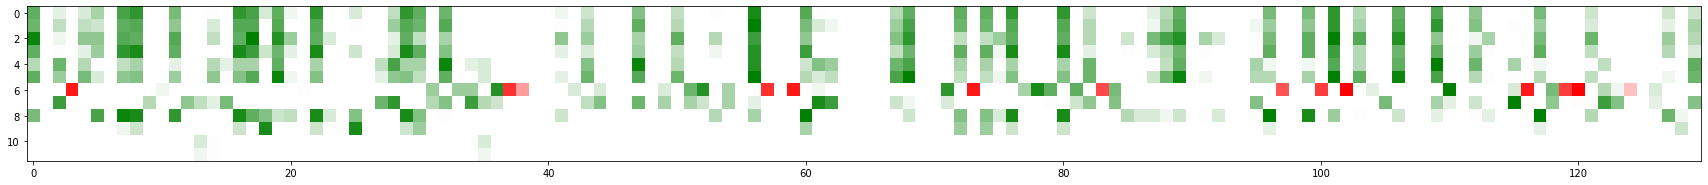

In [38]:
# Heatmap of distances from all helpers to all shops (green = closer, red = further away)
plt.figure(figsize = (30,30))
plt.imshow(HtoS, cmap=greenToRed)
plt.show()

The closest shop to a helper is only 66 meters away, mean distance is about 1 km and variance is obviously very high.

The shop with indice 6 seems to be the one that is furthest away from some of the helpers. If you have a look a the venues datafram, you see, that this is "Restaurant Turbinenhaus". If you look on the map, you can see it's located at the bottom right of the map and therefore naturally far away from helpers on the top left.

#### StoC – distances between shops and customers

In [39]:
print(stats.describe(StoC,axis=None))

DescribeResult(nobs=12, minmax=(105.0, 957.0), mean=482.5833333333333, variance=99210.08333333334, skewness=0.3728582113979914, kurtosis=-1.475914078451692)


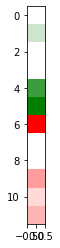

In [40]:
# Heatmap of distances from all shops to our customer (green = closer, red = further away)
plt.imshow(StoC, cmap=greenToRed)
plt.show()

We get a good picture about possible shop recommendations here. The shop with indice 6 also seems to be far away from our customer. It probably won't make it into our recommendation list, then.

**Shops 5,4 and 1 could be potentially interesting when the shop has to be close.**

#### CtoH – distances between our customer and our helpers

In [41]:
print(stats.describe(CtoH,axis=None))

DescribeResult(nobs=130, minmax=(105.0, 2080.0), mean=876.6769230769231, variance=306164.14287418005, skewness=0.6655659563462873, kurtosis=-0.6208715228192303)


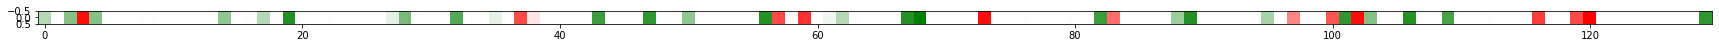

In [42]:
# Heatmap of distances from our customer to all helpers (green = closer, red = further away)
plt.figure(figsize = (30,30))
plt.imshow(CtoH, cmap=greenToRed)
plt.show()

There are quite a few helpers located close to our customer, which is promising.

#### totDist – total distance

Having our 3 matrices in place it is actually really simple now to **calculate our total distance:**

In [43]:
# calculate total distance
totDist=HtoS+StoC+CtoH

Again, we do simple descriptive statistics and a quick heatmap:

In [44]:
print(stats.describe(totDist,axis=None))

DescribeResult(nobs=1560, minmax=(281.0, 6034.0), mean=2379.4070512820513, variance=1379222.639206181, skewness=0.5854207297337536, kurtosis=-0.2367640214900928)


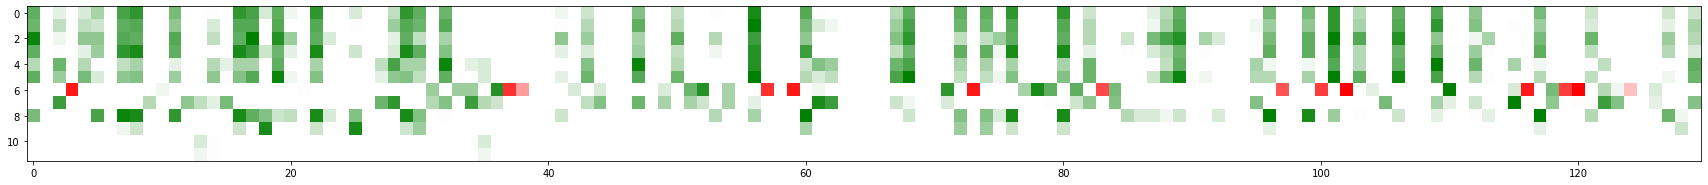

In [45]:
# Heatmap of total distances for all shop and helper combinations (green = closer, red = further away)
plt.figure(figsize = (30,30))
plt.imshow(HtoS, cmap=greenToRed)
plt.show()

Again, we can clearly see that "Restaurant Turbinenhaus" with index 6 will not be a good recommendation. 

### weighting

Now we have 4 different distance measures with totDist clearly being the most important one.

**BUT: Let's consider the case, where the customer orders refrigerated or especially heavy goods.**

As a customer you don't want to receive your refrigerated goods thawed.

As a helper you don't want to lift heavy goods for a long time and over a long distance.

**So total distance won't be the most important measure anymore.** For both cases it would then make sense to **minimize the distance between the shop and the customer**. Even if this means to have a larger total distance than any other helper shop combinations. 

Additionally, refrigerate goods thaw more quickly, the hotter it is. So the local weather needs to be addressed as well.

#### calculation of the weights

Warning: Tuning of the following parameters is based on (somewhat educated) guesses, not sound science.

In [46]:
# function that returns a weight matrix depending on the weather, items purchased and equipment of the helper
def returnWeights (temperature, isRefrigerated=False, isHeavy=False):
    
    # array structure 
    # for weights[HtoS, StoC, StoC_T, CtoH, totDist] -> "_T" means that the helper has a trolley
    w_standard = np.array([0, 0, 0, 0, 10]) # total distance gets optimized, rest omitted
    
    if temperature>30: # StoC gets weighted more the hotter it is (if we have refrigerated items),
                       # for the helper having a trolley (with a thermos bag) helps a to keep the goods cold
        w_refrigerated = np.array([0, 20, 10,  0, 0])
    elif temperature>25:
        w_refrigerated = np.array([0, 10, 5, 0, 0])
    elif temperature>15:
        w_refrigerated = np.array([0, 4, 2, 0, 0])
    else:
        w_refrigerated = np.array([0, 2, 1, 0, 0])

    # StoC gets weighted more for heavy items (3) and even more so if the helper has no trolley (8)
    w_heavy = np.array([0, 20, 10, 0, 0])
    
    # calculate total weight by adding the subweights
    w_total = w_standard + isRefrigerated*w_refrigerated + isHeavy*w_heavy

    # calculate and return normalized weight matrix where all weights sum up to 1
    w_total = w_total / w_total.sum()
    return w_total

We somehow need to get hold of *daily temperature* data that can be used to call our returnWeights function.

For the current purpose we can use the free **openweathermap.org API**.

We simply repeat the same process as for the Foursquare API:

In [47]:
# read Openweathermap.org API credentials like in the example of the foursquare API further above
cred_weather=pd.read_json(r'cred_openweathermap.json')

OWM_VERSION=cred_weather['keys'][0]['scriptvalue'] # Openweathermap API version
OWM_APIKEY=cred_weather['keys'][1]['scriptvalue'] # Openweathermap API key

In [48]:
def getWeatherData (lat, lon, APIKEY, VERSION):
    # create the API request URL
    url = 'https://api.openweathermap.org/data/{}/weather?lat={}&lon={}&appid={}&units=metric'.format(
        VERSION, 
        lat, 
        lon, 
        APIKEY)

    # make the GET request
    results = requests.get(url).json()
    
    return results

In [49]:
# call function to get current weather of our customer location
weather = getWeatherData(custLatitude, custLongitude, OWM_APIKEY, OWM_VERSION)
weather

{'coord': {'lon': 8.5, 'lat': 47.4},
 'weather': [{'id': 500,
   'main': 'Rain',
   'description': 'light rain',
   'icon': '10d'}],
 'base': 'stations',
 'main': {'temp': 19.93,
  'feels_like': 16.91,
  'temp_min': 18.33,
  'temp_max': 21,
  'pressure': 1008,
  'humidity': 32},
 'visibility': 10000,
 'wind': {'speed': 2.1, 'deg': 40},
 'rain': {'3h': 0.33},
 'clouds': {'all': 95},
 'dt': 1587910061,
 'sys': {'type': 1,
  'id': 6941,
  'country': 'CH',
  'sunrise': 1587874624,
  'sunset': 1587925808},
 'timezone': 7200,
 'id': 2658017,
 'name': 'Werdhölzli',
 'cod': 200}

This works fine, the selected weather station 'Werdhölzli' makes sense and data seems to be reasonable for today.

Let's extract the current temperature at our customer location.

In [50]:
# extract max temperature
temp = weather['main']['temp']
print(temp,'°C')

19.93 °C


Let's create a few test cases, where we play around with the parameters and have a look at the changes it produces on  the weight matrix.

In [51]:
print('Now we have a look at what weights are applied when we alter our variables\n')

print('First we\'re getting the current temperature:')
temp=getWeatherData(custLatitude, custLongitude, OWM_APIKEY, OWM_VERSION)['main']['temp']
print('temperature at customer location:',temp,'°C\n')

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) # print floats to only 3 digits precision

print('[HtoS  StoC StoC_T CtoH totDis]')
standard_weights = returnWeights (temp, isRefrigerated=False, isHeavy=False)
print(standard_weights,'-> standard case')

heavy_weights = returnWeights (temp, isRefrigerated=False, isHeavy=True)
print(heavy_weights,'-> heavy items')

frigo_weights = returnWeights (temp, isRefrigerated=True, isHeavy=False)
print(frigo_weights,'-> refrigerated items with today\'s weather')

hot_heavy_frigo_weights = returnWeights (temperature=35, isRefrigerated=True, isHeavy=True)
print(hot_heavy_frigo_weights,'-> heavy and refrigerated item on a hot summer day')

Now we have a look at what weights are applied when we alter our variables

First we're getting the current temperature:
temperature at customer location: 19.93 °C

[HtoS  StoC StoC_T CtoH totDis]
[0.000 0.000 0.000 0.000 1.000] -> standard case
[0.000 0.500 0.250 0.000 0.250] -> heavy items
[0.000 0.250 0.125 0.000 0.625] -> refrigerated items with today's weather
[0.000 0.571 0.286 0.000 0.143] -> heavy and refrigerated item on a hot summer day


So in this setting **total distance gets less weight and the distance from the shop to the customer gets more weight under certain conditions**. Just like we wanted to.

It's also obvious that HtoS and CtoH have no relevance at all in our current setting. So we might as well leave it out completely. But because future relevant use cases might bring importance to those, we'll keep it for now.

The parameter isRefrigerated depends on the food ordered. The trolly on the other hand is something that is determined by the helper.

So let's create a **one hot encoded matrix for trolleys** with 1 indicating that the helper has a trolley:

In [52]:
# generate matrix with length corresponding to our number of helpers and about 20% having a trolley
hTrolley=np.random.choice([0, 1], size=helperData.shape[0], p=[.8, .2])
#hTrolley=hTrolley.reshape((-1, 1))
print(stats.describe(hTrolley,axis=None))

DescribeResult(nobs=130, minmax=(0, 1), mean=0.23846153846153847, variance=0.18300536672629697, skewness=1.2274688184341327, kurtosis=-0.4933202997719137)


Now we're only missing a reusable **function** that applies all this data and returns a **score matrix**:

In [53]:
def calcScores(HtoS, StoC, CtoH, totDist, weights, hTrolley):
    w_HtoS=weights[0]
    w_StoC=weights[1]
    w_StoC_T=weights[2]
    w_CtoH=weights[3]
    w_totDist=weights[4]
    
    return w_HtoS*HtoS + w_StoC*StoC*hTrolley + w_StoC_T*StoC*abs(hTrolley-1) + w_CtoH*CtoH + w_totDist*totDist

This function norms the score matrix by divinging it with the maximum value. This way we get a range from 0 to 1. 1 would be the case, where the helper and the customer live at the same address as the shop.

**So the closer the score to 0, the better:**

In [54]:
def normPerfectToZero(array):
    return array / array.max()

Now we should be all set up.

There could be numerous other parameters applied, e.g. shop rating and so an. But for the purpose of this PoC we'll leave it at that and see what our recommender system returns for our customer.

## Results

### standard case - not refrigerated, not heavy

In [55]:
standard_score = normPerfectToZero(calcScores(HtoS, StoC, CtoH, totDist, standard_weights, hTrolley))

In [56]:
# set font size of plot labels to 24 pt
font = {'size'   : 24}
plt.rc('font', **font)

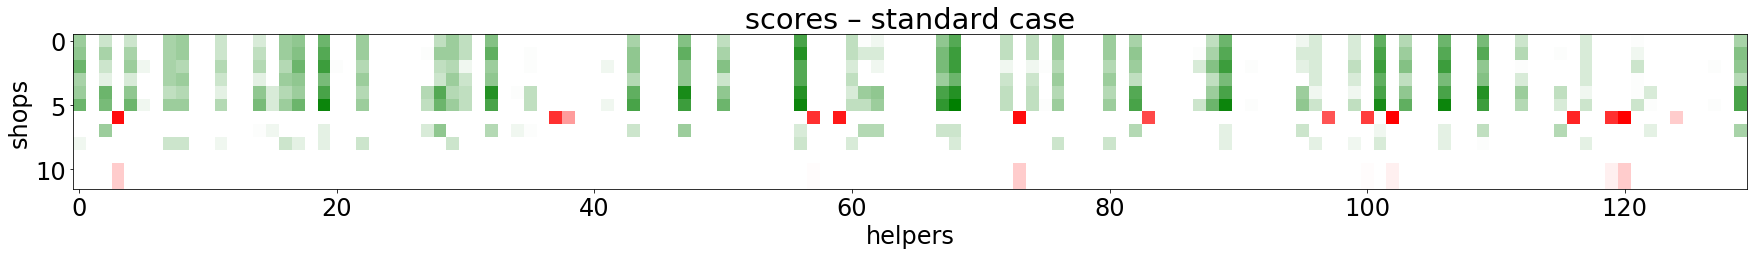

In [57]:
# Heatmap of total distances for all shop and helper combinations
# (green = lower score = better, red = high score = bad choice)
plt.figure(figsize = (30,30))
plt.imshow(standard_score, cmap=greenToRed)
plt.title("scores – standard case")
plt.xlabel('helpers')
plt.ylabel('shops')
plt.show()

In [58]:
stats.describe(standard_score,axis=None)

DescribeResult(nobs=1560, minmax=(0.04656943984090156, 1.0), mean=0.39433328658966715, variance=0.03788120326673271, skewness=0.5854207297337527, kurtosis=-0.23676402149009323)

### heavy items

In [59]:
heavy_score = normPerfectToZero(calcScores(HtoS, StoC, CtoH, totDist, heavy_weights, hTrolley))

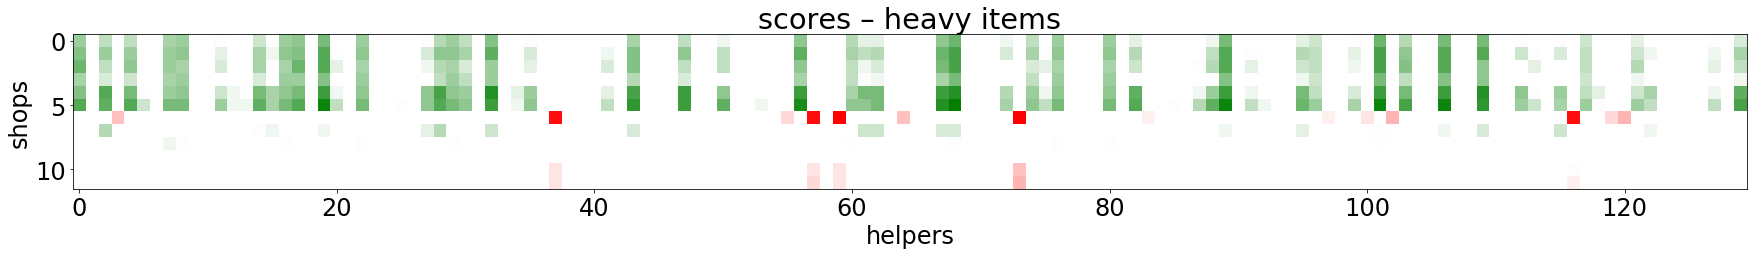

In [60]:
# Heatmap of total distances for all shop and helper combinations
# (green = lower score = better, red = high score = bad choice)
plt.figure(figsize = (30,30))
plt.imshow(heavy_score, cmap=greenToRed)
plt.title("scores – heavy items")
plt.xlabel('helpers')
plt.ylabel('shops')
plt.show()

In [61]:
stats.describe(heavy_score,axis=None)

DescribeResult(nobs=1560, minmax=(0.04902832465388035, 1.0), mean=0.3781364090839513, variance=0.03131248140918763, skewness=0.5316299109179674, kurtosis=-0.04014952503549729)

### refrigerated items

In [62]:
frigo_score = normPerfectToZero(calcScores(HtoS, StoC, CtoH, totDist, frigo_weights, hTrolley))

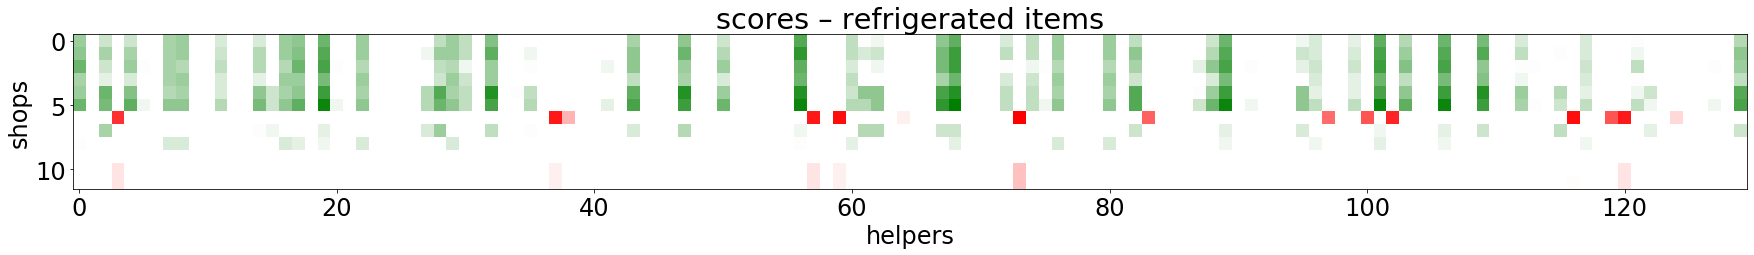

In [63]:
# Heatmap of total distances for all shop and helper combinations
# (green = lower score = better, red = high score = bad choice)
plt.figure(figsize = (30,30))
plt.imshow(frigo_score, cmap=greenToRed)
plt.title("scores – refrigerated items")
plt.xlabel('helpers')
plt.ylabel('shops')
plt.show()

In [64]:
stats.describe(frigo_score,axis=None)

DescribeResult(nobs=1560, minmax=(0.047620549370841085, 1.0), mean=0.39404257951515825, variance=0.03629694972459201, skewness=0.5651590284958143, kurtosis=-0.17996869422459616)

### refrigerated and heavy items on a hot summers day

In [65]:
hot_heavy_frigo_score = normPerfectToZero(calcScores(HtoS, StoC, CtoH, totDist, hot_heavy_frigo_weights, hTrolley))

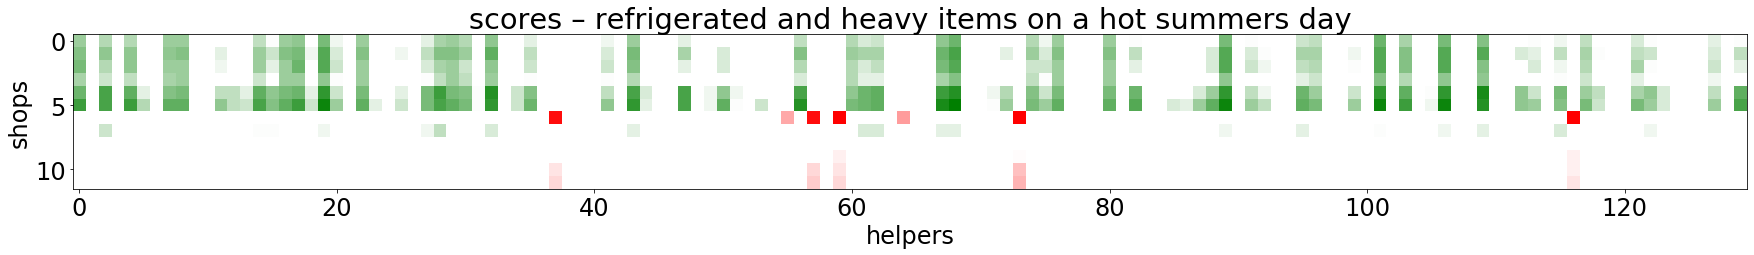

In [66]:
# Heatmap of total distances for all shop and helper combinations
# (green = lower score = better, red = high score = bad choice)
plt.figure(figsize = (30,30))
plt.imshow(hot_heavy_frigo_score, cmap=greenToRed)
plt.title("scores – refrigerated and heavy items on a hot summers day")
plt.xlabel('helpers')
plt.ylabel('shops')
plt.show()

In [67]:
stats.describe(hot_heavy_frigo_score,axis=None)

DescribeResult(nobs=1560, minmax=(0.050168590988045374, 1.0), mean=0.36525276858627226, variance=0.030269464745680003, skewness=0.5951194092669662, kurtosis=0.06004874094664281)

### short analysis

When we have a quick look at the heatmaps of our score matrix, we can see that the score matrix seems to represent what it should and makes sense.

There's shop rows that are either mostly white (shops with medium distance to the customer), white and green (closer shops) or white and red (shops with a larger distance). This is nice.

**Shops 0 to 5 seem to have the highest scores. It's not as clear anymore that shops 5,4 and 1 are closest to the customer since not only StoC has an effect, but also the total distance.**

When we look at the rows in the score matrices, we can clearly see that **helpers are either a fit or not**. There's not a single helper that has both red and green scores with different shops. Then there's helper rows that show no color at all, which are probably the ones having a medium distance to the customer.

Also it's quite striking, that the "standard case" and "refrigerated items case" look quite alike. This is not surprising, since on the day I calculated this, the weather was not particularly hot. So there's only a minor differnece in weighting taking place.

Also the "heavy items case" and the "refrigerated and heavy items on a hot summers day case" share more similarities, with the **extreme combination showing the most differences to the standard case**. This makes sense because there the weighting has the most differences to the standard case.

**This appears to be a good base for making our recommendations.**

### recommendation lists

Now we can list the **top 20 recommendations** (smallest scores and the corresponding helper shop combination):

In [68]:
# function that takes a 2dim numpy array and a number k
# it returns a list with k rows where each row consists of [row index, column index, value]
def findKMinFromNp(originalArray, k):
    array=np.copy(originalArray) # copy the numpy array in order not to change the original array
    dimArray=len(array[0])       # get number of columns
    arrMax=np.amax(array)+1      # get maximum value of array and add 1
    
    res=[] # initialize results list
    for i in range(k): # repeat this step k times
        minIndex=array.argmin()       #find minimum value in array
        row=int(minIndex/dimArray)    # determine row index of min value
        col=minIndex%dimArray         # determine column index of min value
        value=array[row][col]         # save value
        res.append([row, col, value]) # append results in results list in the form [value, row index, column index]
        array[row][col]=arrMax        # overwrite the min value with a value that is larger than the current maximum
                                      # ...to prevent finding the same minimum in the next iteration    
    return res

In [69]:
def printRecommendation(scores, venues):
    for rank, score in enumerate(scores, start=1):
        print(rank,'/ shop:',venues.iloc[score[0]]['Venue'],'/ helper:',helperData.iloc[score[1]]['email'])

In [70]:
standard_recommendation=findKMinFromNp(standard_score,10)
printRecommendation(standard_recommendation, venues)

1 / shop: Marcello's Bistro / helper: zrogge@karz.com
2 / shop: Marcello's Bistro / helper: alexeiholsten@web.de
3 / shop: Marcello's Bistro / helper: bbachmann@web.de
4 / shop: Marcello's Bistro / helper: gerlachgerhardt@gmail.com
5 / shop: Marcello's Bistro / helper: angelicabloch@web.de
6 / shop: Marcello's Bistro / helper: iris38@beyer.de
7 / shop: Pizzeria Rapido / helper: vzirme@tlustek.de
8 / shop: Pizzeria Rapido / helper: selmaaustermuehle@googlemail.com
9 / shop: Pizzeria Rapido / helper: alexeiholsten@web.de
10 / shop: Desperado / helper: alexeiholsten@web.de


In [71]:
heavy_recommendation=findKMinFromNp(heavy_score,10)
printRecommendation(heavy_recommendation, venues)

1 / shop: Marcello's Bistro / helper: zrogge@karz.com
2 / shop: Marcello's Bistro / helper: bbachmann@web.de
3 / shop: Marcello's Bistro / helper: gerlachgerhardt@gmail.com
4 / shop: Marcello's Bistro / helper: angelicabloch@web.de
5 / shop: Marcello's Bistro / helper: iris38@beyer.de
6 / shop: Marcello's Bistro / helper: alexeiholsten@web.de
7 / shop: Pizzeria Rapido / helper: selmaaustermuehle@googlemail.com
8 / shop: Marcello's Bistro / helper: wally73@heydrich.com
9 / shop: Pizzeria Rapido / helper: zrogge@karz.com
10 / shop: Pizzeria Rapido / helper: kreinberta@paertzelt.net


In [72]:
frigo_recommendation=findKMinFromNp(frigo_score,10)
printRecommendation(frigo_recommendation, venues)

1 / shop: Marcello's Bistro / helper: zrogge@karz.com
2 / shop: Marcello's Bistro / helper: alexeiholsten@web.de
3 / shop: Marcello's Bistro / helper: bbachmann@web.de
4 / shop: Marcello's Bistro / helper: gerlachgerhardt@gmail.com
5 / shop: Marcello's Bistro / helper: angelicabloch@web.de
6 / shop: Marcello's Bistro / helper: iris38@beyer.de
7 / shop: Pizzeria Rapido / helper: selmaaustermuehle@googlemail.com
8 / shop: Pizzeria Rapido / helper: vzirme@tlustek.de
9 / shop: Pizzeria Rapido / helper: zrogge@karz.com
10 / shop: Pizzeria Rapido / helper: kreinberta@paertzelt.net


In [73]:
hot_heavy_frigo_recommendation=findKMinFromNp(hot_heavy_frigo_score,10)
printRecommendation(hot_heavy_frigo_recommendation, venues)

1 / shop: Marcello's Bistro / helper: zrogge@karz.com
2 / shop: Marcello's Bistro / helper: bbachmann@web.de
3 / shop: Marcello's Bistro / helper: gerlachgerhardt@gmail.com
4 / shop: Marcello's Bistro / helper: angelicabloch@web.de
5 / shop: Marcello's Bistro / helper: iris38@beyer.de
6 / shop: Marcello's Bistro / helper: wally73@heydrich.com
7 / shop: Pizzeria Rapido / helper: selmaaustermuehle@googlemail.com
8 / shop: Pizzeria Rapido / helper: zrogge@karz.com
9 / shop: Pizzeria Rapido / helper: kreinberta@paertzelt.net
10 / shop: Marcello's Bistro / helper: selmaaustermuehle@googlemail.com


Now isn't that nice. Already in the top 10 recommendations we can see major differences depending on the circumstances.

Since Marcello's Bistro is definitely the closest to our customer, it makes sense that the top 6 recommendations are for this shop. But there's quite some differences in helper choice. Obviously because of the helpers having trolleys or not. 

Take for example alexeiholsten@web.de as number 2 recommendation in the standard case. This helper is also number 2 in the "refrigerated items case" under not so hot circumstances. In the "heavy items case" he's number 6 and in the extreme combo he's not even in the top 10 anymore.

So this works quite well.

So now we have our list. It further is very easy to get to the details of the shop and the helper, once the decision is made. e.g. here's the details for combo from the top of the list:

In [74]:
venues.iloc[standard_recommendation[0][0]]

Customer Email            hungrycustomer1942@bluewin.ch
Neighborhood Latitude                           47.4029
Neighborhood Longitude                          8.49958
Venue                                 Marcello's Bistro
Venue Latitude                                   47.403
Venue Longitude                                 8.49821
Venue Category                                     Café
Name: 5, dtype: object

In [75]:
helperData.iloc[standard_recommendation[0][1]]

address      Kappenbühlweg 9, 8049 Zürich
latitude                          47.4036
longitude                         8.49863
email                     zrogge@karz.com
Name: 68, dtype: object

### create a map of the distances for our top 3 recommendations

Now wouldn't it be nice to see the top 3 recommendations visually on our folium map?

Credit for the following two nice functions, that draw lines with arrows on folium maps, goes to [Bob Haffner](https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e).

In [76]:
def get_arrows(locations, color='blue', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

In [77]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

**Now we can draw the final map:**

standard case:

In [78]:
topHelper=helperData.iloc[standard_recommendation[0][1]]
topVenue=venues.iloc[standard_recommendation[0][0]]
secondHelper=helperData.iloc[standard_recommendation[1][1]]
secondVenue=venues.iloc[standard_recommendation[1][0]]
thirdHelper=helperData.iloc[standard_recommendation[2][1]]
thirdVenue=venues.iloc[standard_recommendation[2][0]]

p=[]

p.append([topHelper['latitude'], topHelper['longitude'], topVenue['Venue Latitude'], topVenue['Venue Longitude'], 'green'])
p.append([topVenue['Venue Latitude'], topVenue['Venue Longitude'], custLatitude, custLongitude, 'green'])
p.append([custLatitude, custLongitude, topHelper['latitude'], topHelper['longitude'], 'green'])

p.append([secondHelper['latitude'], secondHelper['longitude'], secondVenue['Venue Latitude'], secondVenue['Venue Longitude'], 'orange'])
p.append([secondVenue['Venue Latitude'], secondVenue['Venue Longitude'], custLatitude, custLongitude, 'orange'])
p.append([custLatitude, custLongitude, secondHelper['latitude'], secondHelper['longitude'], 'orange'])

p.append([thirdHelper['latitude'], thirdHelper['longitude'], thirdVenue['Venue Latitude'], thirdVenue['Venue Longitude'], 'red'])
p.append([thirdVenue['Venue Latitude'], thirdVenue['Venue Longitude'], custLatitude, custLongitude, 'red'])
p.append([custLatitude, custLongitude, thirdHelper['latitude'], thirdHelper['longitude'], 'red'])

In [79]:
# draw base map with position markers
folium_map=createRawMap(custLatitude, custLongitude, custAddr, helperData, venues, zoomStart=17)

# add lines and arrows
for pos in p:
    p1=[pos[0], pos[1]]
    p2=[pos[2], pos[3]]
    colorLine=pos[4]
    folium.PolyLine(locations=[p1, p2], color=colorLine).add_to(folium_map)

    arrows = get_arrows(locations=[p1, p2], color=colorLine, n_arrows=1)
    for arrow in arrows:
        arrow.add_to(folium_map)
        
display(folium_map)

Now this is really a funny coincidence. 2 of the "helpers" are living at "Tertianum Residenz - Im Brühl". This is a place where you can spend your retirement days.

Maybe not the best location to recruit helpers, when the helpers belong to the risk group themselves.

In real life, of course one would have to make reasonably sure, that the helpers are up for the task.

Since this is only based on fake data extracted from OSINT sources, it's not relevant yet. But either way, this example once again shows that data cleaning is the most important process. Otherwise you'll have a lot of work for your model that ends producing in accordance to the garbage in garbage out principle.

Here maybe it's the janitor and his 18 year old son, both living at the place and young and healthy?

<a id = "tldr2"></a>
### That was fun. Let's try to apply the code to a different customer.

Once you have arrived here, you can easily:
1. plug in a different customer address (custAddr2) down below
2. mark this cell
3. jump to the [end of the notebook](#end) and hit shift and mark the last cell, then...
3. hit run

In [80]:
custAddr_2 = 'Singlistrasse 11, 8049 Zurich' # <-- input address of choice here, then run rest of the notebook

In [81]:
# convert address to location
location_2 = geolocator.geocode(custAddr_2)
custLatitude_2 = location_2.latitude
custLongitude_2 = location_2.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(custAddr_2, custLatitude_2, custLongitude_2))

The geograpical coordinate of Singlistrasse 11, 8049 Zurich are 47.403521, 8.4947084.


In [82]:
venues_2 = getNearbyVenues(names=['hungrycustomer1942@bluewin.ch'],
                             latitudes=[custLatitude_2],
                             longitudes=[custLongitude_2],
                             radius=1000,
                             categories='4d4b7105d754a06374d81259,4bf58dd8d48988d1f9941735,52f2ab2ebcbc57f1066b8b1c,50be8ee891d4fa8dcc7199a7,4bf58dd8d48988d10f951735,4bf58dd8d48988d1fd941735')
venues_2.shape

Searching venues for hungrycustomer1942@bluewin.ch


(9, 7)

In [83]:
# initialize variables
numH_2 = helperData.shape[0] # number of helpers
numS_2 = venues_2.shape[0] # number of shops
numC_2 = 1 # test with only 1 customer
HtoS_2 = np.zeros([numS_2, numH_2]) # 2-dim matrix, helpers in columns, shops in rows
StoC_2 = np.zeros([numS_2,1]) # 1-dim matrix, shops in rows
CtoH_2 = np.zeros([1, numH_2]) # 1-dim matrix, helpers in columns
totDist_2 = np.zeros([numS_2, numH_2]) #2-dim matrix, helpers in columns, shops in rows

In [84]:
# calculate distances from all helpers to all shops (in meters rounded to whole numbers)
for hId, helper in helperData.iterrows():
    for sId, shop in venues_2.iterrows():
        tmpCord1 = (helper['latitude'], helper['longitude'])
        tmpCord2 = (shop['Venue Latitude'], shop['Venue Longitude'])
        HtoS_2[sId][hId]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)

In [85]:
# calculate distances from all shops to our customer (in meters rounded to whole numbers)
tmpCord1 = (custLatitude_2, custLongitude_2)
for sId, shop in venues_2.iterrows():
    tmpCord2 = (shop['Venue Latitude'], shop['Venue Longitude'])
    StoC_2[sId][0]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)

In [86]:
# calculate distances from our customer to all helpers (in meters rounded to whole numbers)
tmpCord2 = (custLatitude_2, custLongitude_2)
for hId, helper in helperData.iterrows():
    tmpCord1 = (helper['latitude'], helper['longitude'])
    CtoH_2[0][hId]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)   

In [87]:
# calculate total distance
totDist_2=HtoS_2+StoC_2+CtoH_2

In [88]:
standard_score2 = normPerfectToZero(calcScores(HtoS_2, StoC_2, CtoH_2, totDist_2, standard_weights, hTrolley))
standard_recommendation2=findKMinFromNp(standard_score2,10)
printRecommendation(standard_recommendation2, venues_2)

1 / shop: Argentina Steakhouse / helper: anneli05@aol.de
2 / shop: Maharani / helper: kuschkarl-august@holzapfel.de
3 / shop: Argentina Steakhouse / helper: olena23@web.de
4 / shop: Osteria da Biagio / helper: kuschkarl-august@holzapfel.de
5 / shop: Argentina Steakhouse / helper: iris38@beyer.de
6 / shop: Osteria da Biagio / helper: metin34@aol.de
7 / shop: Osteria da Biagio / helper: ehoerle@gmail.com
8 / shop: Osteria da Biagio / helper: josef95@boerner.com
9 / shop: Osteria da Biagio / helper: ditschlerinmehdi@googlemail.com
10 / shop: Osteria da Biagio / helper: evelyneloeffler@paertzelt.de


In [89]:
hot_heavy_frigo_score2 = normPerfectToZero(calcScores(HtoS_2, StoC_2, CtoH_2, totDist_2, hot_heavy_frigo_weights, hTrolley))
hot_heavy_frigo_recommendation2=findKMinFromNp(hot_heavy_frigo_score2,10)
printRecommendation(hot_heavy_frigo_recommendation2, venues_2)

1 / shop: Argentina Steakhouse / helper: anneli05@aol.de
2 / shop: Argentina Steakhouse / helper: olena23@web.de
3 / shop: Argentina Steakhouse / helper: iris38@beyer.de
4 / shop: Osteria da Biagio / helper: kuschkarl-august@holzapfel.de
5 / shop: Osteria da Biagio / helper: metin34@aol.de
6 / shop: Osteria da Biagio / helper: ehoerle@gmail.com
7 / shop: Osteria da Biagio / helper: josef95@boerner.com
8 / shop: Osteria da Biagio / helper: ditschlerinmehdi@googlemail.com
9 / shop: Osteria da Biagio / helper: evelyneloeffler@paertzelt.de
10 / shop: Osteria da Biagio / helper: walburgajacob@gmx.de


To display the distances on the map, we need to extract the positions of our top 3 helper shop combinations:

In [90]:
topHelper=helperData.iloc[standard_recommendation2[0][1]]
topVenue=venues_2.iloc[standard_recommendation2[0][0]]
secondHelper=helperData.iloc[standard_recommendation2[1][1]]
secondVenue=venues_2.iloc[standard_recommendation2[1][0]]
thirdHelper=helperData.iloc[standard_recommendation2[2][1]]
thirdVenue=venues_2.iloc[standard_recommendation2[2][0]]
custLat=custLatitude_2
custLong=custLongitude_2

p=[]

p.append([topHelper['latitude'], topHelper['longitude'], topVenue['Venue Latitude'], topVenue['Venue Longitude'], 'green'])
p.append([topVenue['Venue Latitude'], topVenue['Venue Longitude'], custLat, custLong, 'green'])
p.append([custLat, custLong, topHelper['latitude'], topHelper['longitude'], 'green'])

p.append([secondHelper['latitude'], secondHelper['longitude'], secondVenue['Venue Latitude'], secondVenue['Venue Longitude'], 'orange'])
p.append([secondVenue['Venue Latitude'], secondVenue['Venue Longitude'], custLat, custLong, 'orange'])
p.append([custLat, custLong, secondHelper['latitude'], secondHelper['longitude'], 'orange'])

p.append([thirdHelper['latitude'], thirdHelper['longitude'], thirdVenue['Venue Latitude'], thirdVenue['Venue Longitude'], 'red'])
p.append([thirdVenue['Venue Latitude'], thirdVenue['Venue Longitude'], custLat, custLong, 'red'])
p.append([custLat, custLong, thirdHelper['latitude'], thirdHelper['longitude'], 'red'])

**Now we can draw the final map:**

In [91]:
# draw base map with position markers
folium_map=createRawMap(custLatitude_2, custLongitude_2, custAddr_2, helperData, venues_2, zoomStart=16)

# add lines and arrows
for pos in p:
    p1=[pos[0], pos[1]]
    p2=[pos[2], pos[3]]
    colorLine=pos[4]
    folium.PolyLine(locations=[p1, p2], color=colorLine).add_to(folium_map)

    arrows = get_arrows(locations=[p1, p2], color=colorLine, n_arrows=1)
    for arrow in arrows:
        arrow.add_to(folium_map)
        
display(folium_map)

Very nice!

If you want to try with a different customer adress, [simply jump here and have some fun](#tldr2).
<a id = "end"></a>

### **For discussion and conclusion you can [have a look at the full report here](https://github.com/Funisher-code/Coursera_Capstone/blob/master/report/COVID-19_Safe_And_Efficient_Food_Deliveries.md).**

----

### And now?

The goal was to build a simple PoC of a recommender system.

Goal achieved.

But of course there is lots of room for improvement!

**I hope you enjoyed following the code as much as I did piecing it together.**

If you have suggestions or remarks, you can reach me [here](https://www.linkedin.com/in/markus-maechler/).

----